## This notebook is available on Github!
github.com/kfoynt/LocalGraphClustering/ then 
navigate to `notebooks/Demo-Local-Graph-Algorithms.ipynb`

In [10]:
import networkx as nx
import localgraphclustering as lgc # This is US!!
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pandas as pd

## Build a simple graph that has structure we can easily study with our local algorithms. 
This graph is going to have a backbone of geometric structure, but then pockets of local structure. 

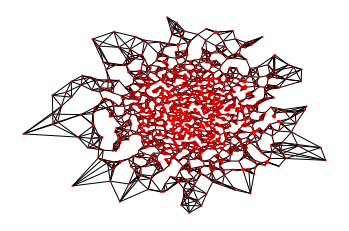

In [4]:
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph

"""
Generate m groups of n points that all have spatial variation sigma
with random coordinates. Add p additional points with spatial variation
rho. These determine the coordinates. Now, add edges to k nearest neighbors
and also within radius eps. 
""" 
def rand_size_geometric_block_model(n,m,sigma,p,rho,k,eps):
    # generate coordinates for each group mean.
    C = rho*np.random.randn(m,2)+np.array([rho/2,rho/2])
    X = np.zeros((0,2))
    for i in range(C.shape[0]):
        ng = np.random.randint(n+1)
        X = np.vstack([X,sigma/np.log10(ng)*np.random.randn(ng,2) + C[i,:]])
    # add random points. 
    X = np.vstack([X,rho*np.random.randn(p,2)])
    
    # see from sklearn.neighbors import NearestNeighbors
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.radius_neighbors_graph.html
    A1 = kneighbors_graph(X, k, include_self=False)
    A2 = radius_neighbors_graph(X, eps, include_self=False)
    A = A1+A2
    N = nx.from_scipy_sparse_matrix(A)
    G = lgc.GraphLocal.from_networkx(N)
    G.discard_weights()
    return X,N,G

np.random.seed(1)
#X,N,G = geometric_block_model(150,10,0.05,1500,5.0,3,0.05,1)
X,N,G = rand_size_geometric_block_model(100,25,0.05,2000,5.0,5,0.06)
#plt.scatter(X[:,0], X[:,1])
G.draw(X,alpha=0.5)
G.discard_weights()


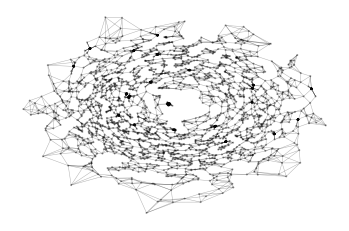

In [5]:
## See if we can get a slightly better drawing.
Xc = X-np.mean(X)
# look at each point and do a log-transform of the radial component
Xc = Xc/(2*np.max(Xc))
def radial_power(X,p):
    Xr = X.copy()
    offset = 0.00
    for i in range(Xr.shape[0]):
        #z = complex(Xr[i,0],Xr[i,1])
        r = np.linalg.norm(Xr[i,:])
        theta = np.arctan2(Xr[i,0],Xr[i,1])
        rt = (max(np.power(r+offset,p),np.power((r+offset),p)))-offset
        Xr[i,0] = rt*np.cos(theta)
        Xr[i,1] = rt*np.sin(theta)
    return Xr
#G.draw(radial_power(X,0.1))
G.draw(radial_power(Xc,0.6),edgealpha=0.3,nodesize=4,nodealpha=0.2,linewidth=0.5,nodecolor='k')
Xc = radial_power(Xc,0.6)

In [11]:
#np.argwhere(Xc[:,1] <= -0.7)
# tweak the lowest position
Xc[2878,1]=-0.71

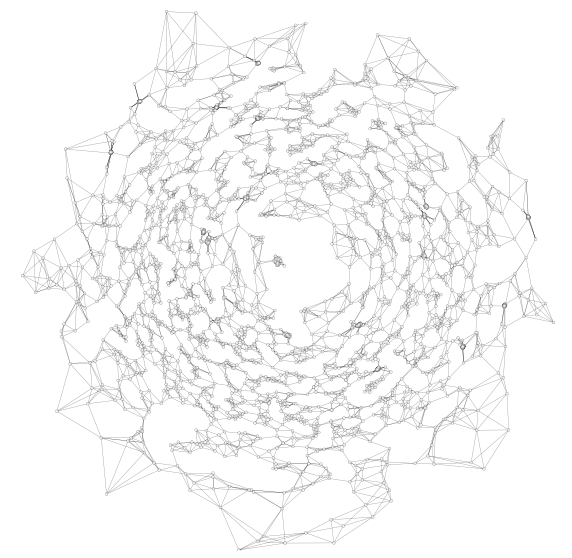

In [12]:
drawing = G.draw(Xc,edgealpha=0.5,
                 nodesize=8,nodealpha=1,
                 linewidth=0.3,nodecolor=['w'],figsize=(10,10))
drawing.nodewidth(range(G._num_vertices),0.2)
drawing.nodecolor(range(G._num_vertices),edgecolor='k',alpha=0.5)
plt.xlim([-0.712,0.64])
plt.ylim([-0.712,0.64])
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

The following shows a pocket of local structure at the center of the graph.

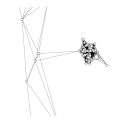

In [13]:
drawing = G.draw(Xc,edgealpha=0.25,nodesize=6,nodealpha=1,linewidth=0.5,nodecolor=['w'],figsize=(2,2))
drawing.nodewidth(range(G._num_vertices),0.2)
drawing.nodecolor(range(G._num_vertices),edgecolor='k',alpha=0.5)
plt.xlim([-0.13,-0.03])
plt.ylim([-0.05,0.05])
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

## Global spectral clustering

In [14]:
f = lgc.fiedler(G)

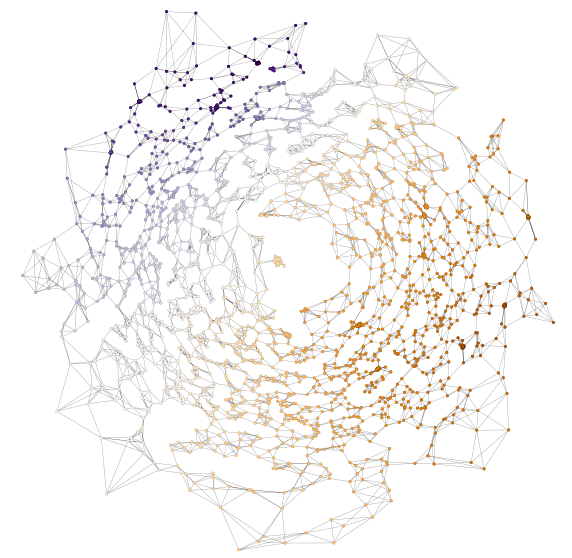

In [15]:
drawing = G.draw(Xc,edgealpha=0.5,nodesize=8,nodealpha=1,linewidth=0.3,nodecolor=['w'],figsize=(10,10),
                 values=f[0],valuecenter=0)
drawing.nodewidth(range(G._num_vertices),0.1)
drawing.nodecolor(range(G._num_vertices),edgecolor='k',alpha=0.5)
plt.xlim([-0.712,0.64])
plt.ylim([-0.712,0.64])
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

In [18]:
Sf,cond = lgc.spectral_clustering(G,[],method='fiedler')

/Users/dgleich/Library/Python/3.7/lib/python/site-packages/localgraphclustering/spectral_clustering.py:120: UserWarning:

ref_nodes will be discarded since we are computing a global fiedler vector.



In [20]:
cond

0.0010348706411698538

In [21]:
# Here, we get the same thing if we did the sweepcut ourselves. 
sweepset,cond = lgc.sweep_cut(G,f[0])
print(cond)

0.0010348706411698538


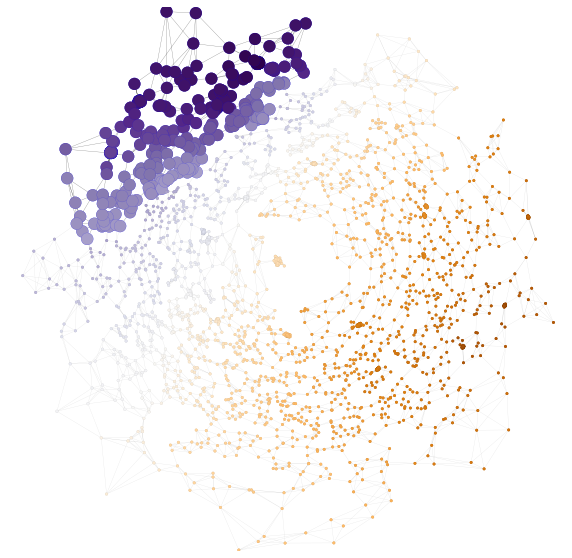

In [22]:
drawing = G.draw(Xc,edgealpha=0.5,nodesize=8,nodealpha=1,
                 linewidth=0.3,nodecolor=['w'],figsize=(10,10),
                 values=f[0],valuecenter=0)
drawing.nodewidth(range(G._num_vertices),0.2)
drawing.nodecolor(range(G._num_vertices),edgecolor='k',alpha=0.5)
plt.xlim([-0.712,0.64])
plt.ylim([-0.712,0.64])
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
drawing.highlight(Sf)

## Local spectral clustering using ACL Approximate PageRank

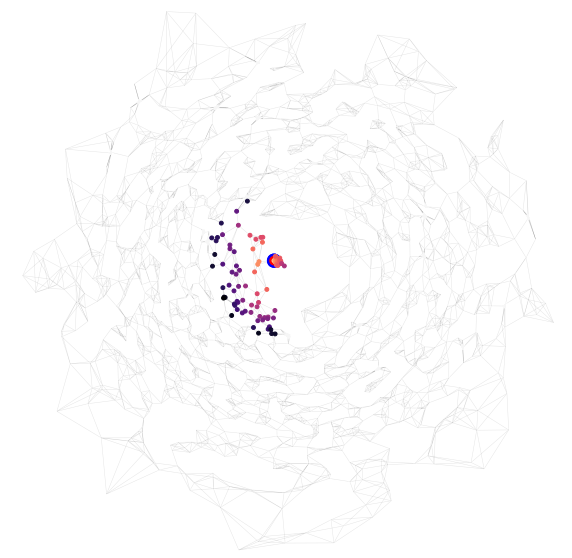

In [23]:
seed = [320]
acl = lgc.approximate_PageRank(G,seed,normalize=False)
drawing = G.draw(Xc,nodesize=8,nodealpha=0.5,linewidth=0.5,
                 figsize=(10,10),edgealpha=0.5,nodecolor='w')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().scatter(Xc[acl[0],0],Xc[acl[0],1],c=np.log10(acl[1]),cmap=plt.magma(),s=15,zorder=3)
plt.xlim([-0.712,0.64])
plt.ylim([-0.712,0.64])
drawing.highlight(seed)

0.002787068004459309

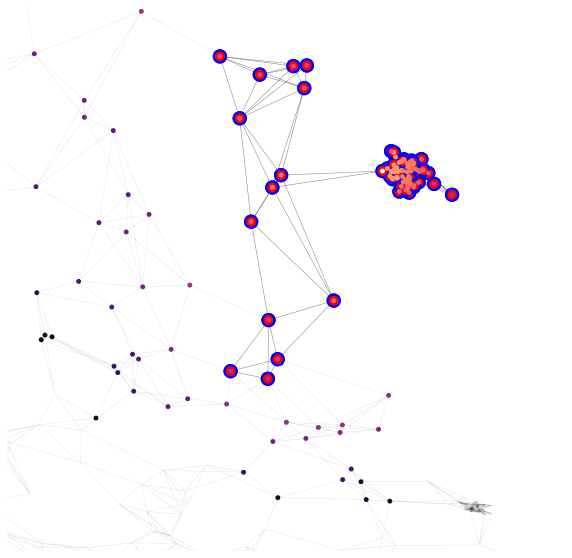

In [24]:
acl = lgc.approximate_PageRank(G,seed,normalize=False)
Sacl,cond = lgc.sweep_cut(G,acl)

drawing = G.draw(Xc,nodesize=8,nodealpha=0.5,linewidth=0.5,
                 figsize=(10,10),edgealpha=0.5,nodecolor='w')
drawing.highlight(Sacl)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.gca().scatter(Xc[acl[0],0],Xc[acl[0],1],c=np.log10(acl[1]),cmap=plt.magma(),s=15,zorder=3)
plt.xlim([-0.2,0])
plt.ylim([-0.2,0.1])
cond

In [25]:
Sacl,condacl = lgc.spectral_clustering(G,[320],method="acl") # one step
print(condacl)
Smqi,condmqi = lgc.flow_clustering(G,Sacl,method="mqi")
print(condmqi)



0.002787068004459309
0.0005704506560182544


In [27]:
# Question from audience, what happens if you try something that isn't explicitly on the boundary of the set?? 
Smqi

array([ 283,  329,  327,  326,  325,  324,  323,  322,  321,  320,  319,
        318,  317,  316,  315,  314,  313,  312,  311,  310,  308,  307,
        306,  304,  303,  302,  301,  300,  299,  298,  297,  296,  294,
        291,  290,  289,  288,  287,  286,  285,  284,  277,  282,  281,
        280,  279,  278,  273,  276,  275,  271,  293,  309,  270,  269,
        268,  267, 2287,  266,  262,  260,  263,  328,  265,  305,  259,
        264,  292,  261,  272,  295,  274], dtype=uint32)

In [32]:
# Let's pick node 286
seed = [286]
Sacl,condacl = lgc.spectral_clustering(G,seed,method="acl") # one step
print(condacl)

0.0005704506560182544


In [34]:
Smqi,condmqi = lgc.flow_clustering(G,Sacl,method="mqi")
print(condmqi)

0.0005704506560182544


## I should move the preceeding 3 cells down later! 

(-0.2, 0.1)

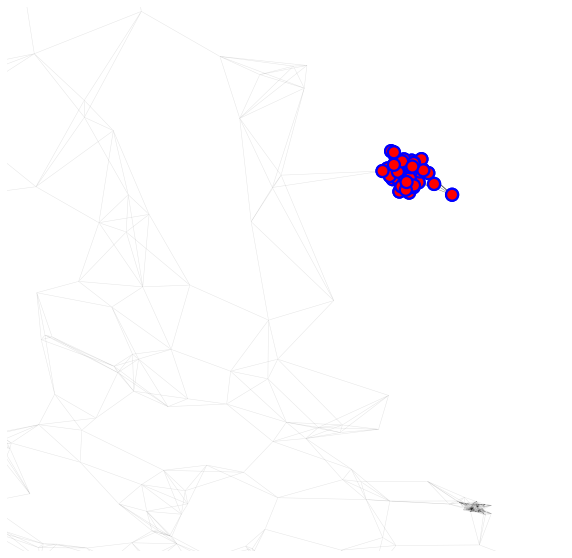

In [26]:
drawing = G.draw(Xc,nodesize=8,nodealpha=0.5,linewidth=0.5,
                 figsize=(10,10),edgealpha=0.5,nodecolor='w')
drawing.highlight(Smqi)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.xlim([-0.2,0])
plt.ylim([-0.2,0.1])

0.03540903540903541
0.02711323763955343
0.007503410641200546


Text(0.5, 1.0, 'SimpleLocal -- $\\phi = 0.0075$')

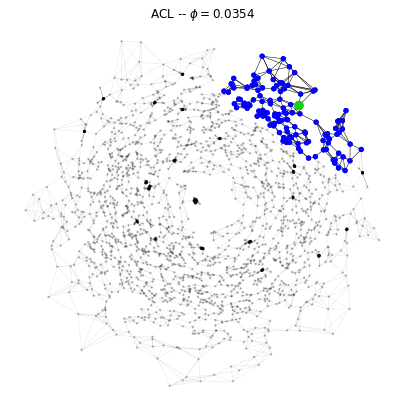

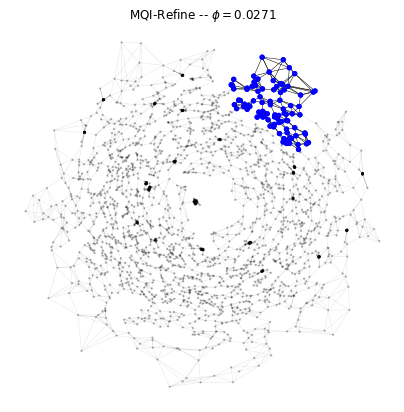

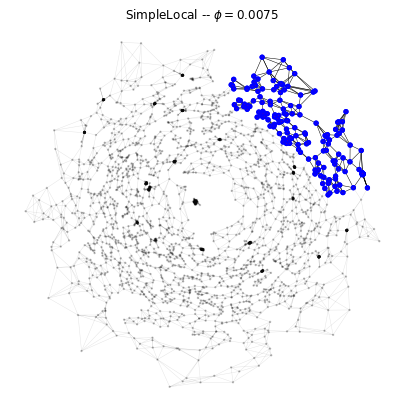

In [35]:
seed = [1500]
S,cond = lgc.spectral_clustering(G,seed)
cond
drawing = G.draw(Xc,nodesize=2,nodecolor='k',linewidth=0.5,figsize=(7,7))
drawing.highlight(S)
#drawing.highlight(seed,size=10)
#drawing.nodecolor(seed,'r')
drawing.nodecolor(seed,[0.1,0.8,0.1])
drawing.nodesize(seed,50)
plt.title(r'ACL -- $\phi = %.4f$'%(cond))
print(cond)


R,cond = lgc.flow_clustering(G,S,method="mqi")
print(cond)


drawing = G.draw(Xc,nodesize=2,nodecolor='k',linewidth=0.5,figsize=(7,7))
drawing.highlight(R)
plt.title(r'MQI-Refine -- $\phi = %.4f$'%(cond))

R,cond = lgc.flow_clustering(G,S,method="sl",delta=0.001)
print(cond)


drawing = G.draw(Xc,nodesize=2,nodecolor='k',linewidth=0.5,figsize=(7,7))
drawing.highlight(R)
plt.title(r'SimpleLocal -- $\phi = %.4f$'%(cond))


## There are both local flow and local spectral algorithms.
MQI finds the _optimal_ conductance set contained within a 
reference set that isn't too large. There is a spectral-based analog
that Fan Chung wrote about in a less-well known paper. The idea is that we can solve the eigenvalue problem with a boundary fixed. This is something we call SpectralMQI

In [33]:
Sacl,condacl = lgc.spectral_clustering(G,[320],method="acl") # one step
print(condacl)
Smqi,condmqi = lgc.flow_clustering(G,Sacl,method="mqi")
print(condmqi)
Ssmqi,condsmqi = lgc.spectral_clustering(G,Sacl,method="fiedler_local")
print(condsmqi)

0.002787068004459309
0.0005704506560182544
0.0005704506560182544


We can do similar things with the other example too. 

0.03540903540903541
0.031133250311332503
0.013582554517133956


Text(0.5, 1.0, 'ACL-ACL -- $\\phi = 0.0136$')

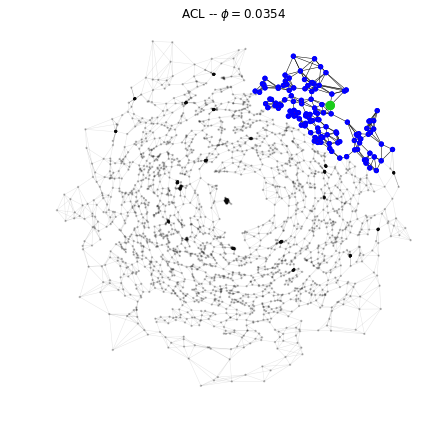

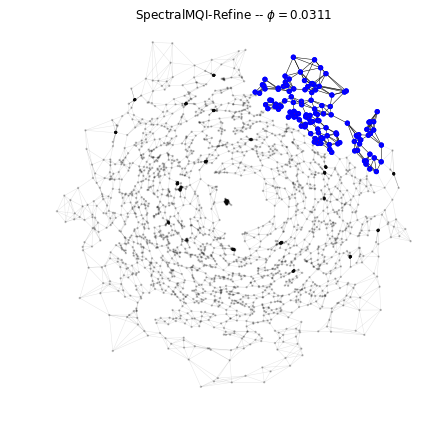

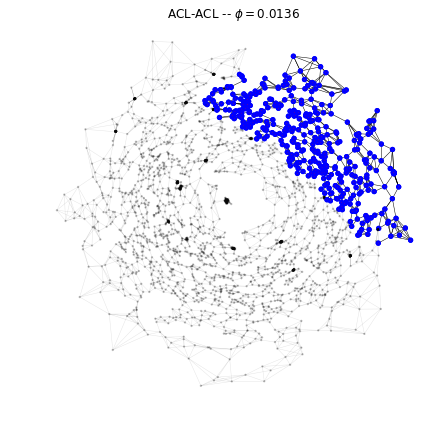

In [34]:
seed = [1500]
S,cond = lgc.spectral_clustering(G,seed)
cond
drawing = G.draw(Xc,nodesize=2,nodecolor='k',linewidth=0.5,figsize=(7,7))
drawing.highlight(S)
#drawing.highlight(seed,size=10)
#drawing.nodecolor(seed,'r')
drawing.nodecolor(seed,[0.1,0.8,0.1])
drawing.nodesize(seed,50)
plt.title(r'ACL -- $\phi = %.4f$'%(cond))
print(cond)


R,cond = lgc.spectral_clustering(G,S,method="fiedler_local")
print(cond)


drawing = G.draw(Xc,nodesize=2,nodecolor='k',linewidth=0.5,figsize=(7,7))
drawing.highlight(R)
plt.title(r'SpectralMQI-Refine -- $\phi = %.4f$'%(cond))

R,cond = lgc.spectral_clustering(G,S)
print(cond)


drawing = G.draw(Xc,nodesize=2,nodecolor='k',linewidth=0.5,figsize=(7,7))
drawing.highlight(R)
plt.title(r'ACL-ACL -- $\phi = %.4f$'%(cond))
